# Breve instrução para rodar o código

O notebook contido aqui se trata de todas as etapas necessárias para contemplar os resultados finais, e essas etapas condizem no Pre-Processamento, no Modelo, nos Resultados e nas Análises. Partindo disso, logo abaixo haverá alguns pontos de atenção a se seguir para a rodagem do código:

- Rode todas as células na ordem em que elas aparecerem;
- Descrições e inforamções necessárias para a rodagem estão concentradas nas seções do card, leia com atenção;
- Como se trata de um notebook no Colab, fique atento que será necessário fazer upload do dataset no seu próprio drive;

**Estrutura ofical do notebook:**

- Configurações e variáveis de ambiente
- Download e Importação de Bibliotecas
- Pré Processamento
  - Data Augmentation
  - Separação dos sub-conjuntos
  - Carregamento em Lotes
- Construção do Modelo e Execução
  - Funções de Métrica
  - Implementação do Modelo
    - Backbone
    - Função de Perda
    - Early Stopping
    - Modelo
      - Criação do Modelo
      - Compilador do Modelo
      - Treinamento do Modelo
  - Visualização de Desempenho
    - Comparação da Minimização da Perda entre os Sub-conjuntos
    - Comparação das métricas Recall e Specificity
- Visualização de Performance
  - Predição do Modelo
  - Visualização de Imagens para Comparação
  - Gráfico de Dispersão Comparando o Recall x Specificity
  - Pós-Processamento
    - Instruções de uso
    - Plotagem do resultado
- Uso da GPU e CPU
  - Análise

# Configurações e variáveis de ambiente

Nesta etapa, configuramos as variáveis de ambiente, colocando o caminho dos respectivos arquivos utilizados

### Instruções para deploy

A célula define as variáveis de ambiente para os caminhos dos arquivos de: requisitos, imagens e labels.

### Aspectos relevantes:
- Configurações e Variáveis de Ambiente: centraliza as configurações em um único local, facilitando a adaptação do código a ambientes diferentes;
- Qualidade do Código: utiliza nomes de variáveis em maiúsculas para indicar que são constantes, o que melhora a legibilidade.

In [1]:
REQUIREMENTS = "/content/requirements.txt" # Caminho do arquivo requirements.txt
PATH_IMAGES_TRAIN_VAL = "/content/drive/MyDrive/sem_mask/" # Caminho da pasta que contem as imagens para treino
PATH_IMAGES_TRAIN_GROUND_TRUTH = "/content/drive/MyDrive/mask_borda/" # Caminho da pasta que contem as imagens para label

Referências do modelo e base de dados

- Biblioteca segmentation_models para construção do modelo: Yakubovskiy, P. (2019). Segmentation Models. GitHub. https://github.com/qubvel/segmentation_models;
- Artigo para inspiração de construção do modelo do U-Net com VGG16 como backbone: https://www.spiedigitallibrary.org/journals/journal-of-applied-remote-sensing/volume-16/issue-3/034511/Segmentation-of-wheat-farmland-with-improved-U-Net-on-drone/10.1117/1.JRS.16.034511.short#_=
- Base de Dados sem_mask: Imagens sintéticas geradas pela instituição Inteli;
- Base de Dados mask_borda: Imagens sintéticas geradas pela instituição Inteli;

# Download e Importação de Bibliotecas

### Instruções para deploy

A célula monta o Google Drive no ambiente Colab para acesso aos dados

### Aspectos relevantes:
- Gerenciamento de Dependências: utiliza a biblioteca "google.colab" para interagir com o Google Drive.

In [2]:
# Conexão com o Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Instruções para deploy
A célula instala as bibliotecas listadas no arquivo "requirements.txt"

### Aspectos Relevantes:
- Gerenciamento de Dependências: garante que as versões corretas das bibliotecas sejam instaladas para reprodutibilidade do ambiente.

Importando as bibliotecas especificadas no arquivo requirements.txt

In [3]:
!pip install -r "/content/drive/MyDrive/dataset_inteli/requirements.txt"

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-c1x4fy4q
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models /tmp/pip-req-build-c1x4fy4q
  Resolved https://github.com/qubvel/segmentation_models to commit e951c6747f75fa9e7240816d1c79dd2e66813123
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.9 MB/s eta 0:00:00
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33787 sha256=61439a85732dfc6c69844bef9e7d5e6c9daa87b48d54e92fd80d6aecb59bdd1f
  Stored in directory: /tmp/pip-ephem-wheel-cache-r3ff1hf4/wheels/ce/d6/f1/5d00e82b3893c5f1ffee43bf7b8877148af09c7c9c6c4882c9
Successfully built segmentation-models


### Instruções para deploy
A célula importa outras bibliotecas necessárias para o bom funcionamento do projeto

### Aspectos Relevantes:
- Modularidade: bibliotecas importadas individualmente, facilitando a identificação de dependências;
- Qualidade do Código: utiliza *aliases* para biliotecas com nomes longos (ex: pd para pandas), tornando a legibilidade.

In [4]:
# Importa as bibliotecas necessárias

import os  # Interação com o sistema operacional
os.environ["SM_FRAMEWORK"] = "tf.keras"
import numpy as np  # Operações eficientes em arrays
import pandas as pd  # Manipulação e análise de dados
from PIL import Image  # Manipulação e processamento de imagens
import matplotlib.pyplot as plt  # Criação de gráficos e visualizações
import random  # Geração de números aleatórios
import keras  # API para redes neurais em TensorFlow
from keras import layers  # Componentes de construção de redes neurais
from keras.models import Sequential  # Modelo sequencial em Keras
from keras.optimizers import Adam  # Otimizador Adam em Keras
from sklearn.model_selection import train_test_split  # Divisão de dados em treino e teste
import tensorflow as tf  # Plataforma de aprendizado de máquina
from sklearn.metrics import accuracy_score, recall_score, precision_score  # Métricas de avaliação
import time  # Manipulação de tempo e medição de desempenho
import psutil  # Monitoramento de recursos do sistema
import segmentation_models as sm  # Modelos de segmentação pré-treinados
from segmentation_models import Unet  # Modelo U-Net para segmentação
from tensorflow import keras  # API de alto nível para construir e treinar modelos em TensorFlow
from tensorflow.keras import backend as K  # Funções de baixo nível para construção de redes neurais
from skimage import measure as meas  # Processamento e análise de imagens
from scipy.ndimage import zoom  # Operações de zoom em imagens
from keras.metrics import IoU # Métrica usada para avaliar o desempenho da detecção de objetos
import cv2 # Biblioteca OpenCV para aplicar erosão e dilatação no pós-processamento
from keras.utils import Sequence # Importação de biblioteca do Sequence para criação de gerador de código

Segmentation Models: using `tf.keras` framework.


Lista de versões das dependências:

- numpy = 1.21.0 (Operações eficientes em arrays)
- pandas = 1.3.0 (Manipulação e análise de dados)
- Pillow = 8.2.0 (Manipulação e processamento de imagens)
- matplotlib = 3.4.2 (Criação de gráficos e visualizações)
- keras = 2.4.3 (API para redes neurais em TensorFlow)
- scikit-learn = 0.24.2 (Métricas de avaliação e divisão de dados)
- tensorflow = 2.5.0 (Plataforma de aprendizado de máquina)
- psutil = 5.8.0 (Monitoramento de recursos do sistema)
- segmentation-models = 1.0.1 (Modelos de segmentação pré-treinados)
- scikit-image = 0.18.1 (Processamento e análise de imagens)
- scipy = 1.7.0 (Operações de zoom e outras funções científicas)
- opencv-python = 4.5.2.52 (Biblioteca OpenCV para processamento de imagens)

# Pré Processamento

Funções criadas para pré processar os datasets, dentre as técnicas implementadas estão:

- Carregamento de Imagens;
- Conversão para escala de cinza;
- Corte de Imagens para tamanho 192x192;

**Instruções**:

Rode as células presentes nesta seção, de modo a garantir que os paths das imagens na seção "Configurações e Variáveis de Ambiente" estejam devidamente colocados;


### Instruções para deploy

Implementação da função load_images que carrega as imagens e transforma em escala de cinza

### Aspectos Relevantes

Encapsulamento: Devido ao código abaixo conter pucas técnicas, isso garante maior facilitação na manutenção no código e futura escalabilidade.

Referências:

O código abaixo reutiliza métodos provindos da biblioteca do Pillow:

https://pillow.readthedocs.io/en/stable/

Além disso, foi tido como auxiliar as medidas incentivadas pelo livro, visto que contém muitas citações de como fazer o pré processamento de imagens efetivo para um modelo CNN:

GERON, Aurélien. Mãos à obra: aprendizado de máquina com Scikit-Learn, Keras e TensorFlow. 2. ed. Rio de Janeiro: Alta Books, 2020.

In [5]:
def load_images(path_images):
    # Inicializa um contador para contar o número de imagens carregadas
    count = 0

    # Inicializa uma lista vazia para armazenar as imagens carregadas
    all_images_train = []

    # Itera sobre todos os arquivos no diretório especificado por path_images
    for file in os.listdir(path_images):
        # Abre a imagem usando a biblioteca PIL
        image = Image.open((path_images + file))

        # Converte a imagem para RGB e a transforma em um array NumPy
        transform_image = np.array(image.convert("RGB"))

        # Verifica se o diretório é o especificado por PATH_IMAGES_TRAIN_GROUND_TRUTH
        if path_images == PATH_IMAGES_TRAIN_GROUND_TRUTH:
            # Se for, converte a imagem para escala de cinza (L) e a transforma em um array NumPy
            transform_image = np.array(image.convert("L"))

        # Adiciona a imagem transformada à lista all_images_train
        all_images_train.append(transform_image)

        # Incrementa o contador
        count += 1

        # Se o contador atingir 300, interrompe o loop
        if count == 300:
            break

    # Retorna a lista de imagens carregadas como um array NumPy
    return np.array(all_images_train)

### Instruções para deploy

Execução da função acima nos datasets de label e imagens que serão usadas no modelo

### Aspectos Relevantes

Qualidade do Código: Código implementado seguindo as práticas do código limpo.

In [6]:
# Carrega imagens de treinamento e validação do caminho especificado pela constante PATH_IMAGES_TRAIN_VAL
# A função load_images é chamada com o argumento PATH_IMAGES_TRAIN_VAL, que deve ser um caminho para um diretório contendo imagens.
# O resultado é armazenado na variável images_entry, que será um array NumPy contendo as imagens carregadas.
images_entry = load_images(PATH_IMAGES_TRAIN_VAL)

# Carrega imagens de referência (ground truth) do caminho especificado pela constante PATH_IMAGES_TRAIN_GROUND_TRUTH
# A função load_images é chamada novamente, agora com o argumento PATH_IMAGES_TRAIN_GROUND_TRUTH.
# O resultado é armazenado na variável images_label, que será um array NumPy contendo as imagens de referência.
images_label = load_images(PATH_IMAGES_TRAIN_GROUND_TRUTH)

### Data Augmentation

De acordo com o livro "Mãos à obra: aprendizado de máquina com Scikit-Learn, Keras e TensorFlow. 2. ed" o cut é considerado como forma de augmentation.

**Instruções**:

Devido a sua natureza simplificada, o necessário para rodagem é apenas clicar sob as células encontradas nesta seção.

### Instruções para deploy

Implementação da função cut_images que corta as imagens

### Aspectos Relevantes

Encapsulamento: Devido ao código abaixo conter pucas técnicas, isso garante maior facilitação na manutenção no código e futura escalabilidade.

Referências:

O código abaixo reutiliza métodos provindos da biblioteca do Pillow:

https://pillow.readthedocs.io/en/stable/

Além disso, foi tido como auxiliar as medidas incentivadas pelo livro, visto que contém muitas citações de como fazer o pré processamento de imagens efetivo para um modelo CNN:

GERON, Aurélien. Mãos à obra: aprendizado de máquina com Scikit-Learn, Keras e TensorFlow. 2. ed. Rio de Janeiro: Alta Books, 2020.

In [7]:
def cut_images(macro_matrices, size, isLabel=False):
    # Inicializa uma lista vazia para armazenar as imagens cortadas
    cropped_images = []

    # Itera sobre cada imagem na lista de macro_matrices
    for image_data in macro_matrices:
        # Extrai as dimensões da imagem atual
        if isLabel:
            # Se for uma imagem de rótulo (label), assume que é em escala de cinza
            height, width = image_data.shape
        else:
            # Se for uma imagem normal (colorida), considera os canais de cor
            height, width, channel = image_data.shape

        # Calcula o número de mini-imagens em cada direção
        num_mini_images_h = height // size
        num_mini_images_w = width // size

        # Loop para cortar a imagem grande em várias mini-imagens
        for i in range(num_mini_images_h):
            for j in range(num_mini_images_w):
                # Calcula as coordenadas de início e fim para o corte
                start_h = i * size
                start_w = j * size
                end_h = start_h + size
                end_w = start_w + size

                # Aplica o corte apenas nas dimensões espaciais (altura e largura)
                if isLabel:
                    # Se for uma imagem de rótulo, corta sem considerar canais de cor
                    cropped_img = image_data[start_h:end_h, start_w:end_w]
                else:
                    # Se for uma imagem normal, corta considerando os canais de cor
                    cropped_img = image_data[start_h:end_h, start_w:end_w, :]

                # Adiciona a mini-imagem cortada à lista cropped_images
                cropped_images.append(cropped_img)

    # Converte a lista de imagens cortadas em um array NumPy
    return np.array(cropped_images)

### Instruções para deploy

Execução da função acima nos datasets de label e imagens que serão usadas no modelo

### Aspectos Relevantes

Qualidade do Código: Código implementado seguindo as práticas do código limpo.

In [8]:
# Chama a função cut_images para cortar as imagens de entrada em mini-imagens de tamanho 192x192 pixels
# A variável images_entry contém as imagens de treinamento e validação carregadas anteriormente
# O resultado é armazenado na variável cropped_images, que será um array NumPy contendo as mini-imagens cortadas
cropped_images = cut_images(images_entry, 192)

# Chama a função cut_images novamente para cortar as imagens de rótulo (ground truth) em mini-imagens de tamanho 192x192 pixels
# A variável images_label contém as imagens de referência carregadas anteriormente
# O terceiro argumento, True, indica que estas são imagens de rótulo (em escala de cinza)
# O resultado é armazenado na variável cropped_labels, que será um array NumPy contendo as mini-imagens de rótulo cortadas
cropped_labels = cut_images(images_label, 192, True)

### Separação dos Sub-conjuntos

Separação dos sub-conjuntos (teste, validação e treino), no final a divisão ficará assim:

- Imagens de treino com 1620 imagens;
- Imagens de teste com 540 imagens;
- Imagens de validação com 540 imagens;

### Instruções para deploy
A célula divide os dados aumentados em conjuntos de treino, validação e teste.

### Aspectos Relevantes:
- Qualidade do Código: utiliza a função *train_test_split* do scikit-learn para dividir os dados de forma aleatória e consistente;
- Reutilização de Código: a função *train_test_split* pode ser reutilizada para dividir outros conjuntos de dados.

In [9]:
# Divide os conjuntos de dados em treinamento e teste, com 20% dos dados destinados ao conjunto de teste e definindo a semente aleatória como 42
x_train_augmentation, x_test_augmentation, y_train_augmentation, y_test_augmentation = train_test_split(cropped_images, cropped_labels, test_size=0.2, random_state=42)

# Divide o conjunto de treinamento anterior em conjuntos de treinamento e validação com 25% dos dados destinados ao conjunto de validação e mantendo a mesma semente aleatória
x_train_augmentation, x_val_augmentation, y_train_augmentation, y_val_augmentation = train_test_split(x_train_augmentation, y_train_augmentation, test_size=0.25, random_state=42)

### Carregamento em lotes

A classe GeradorSequencias, herdada de Sequence do Keras, gera lotes de dados durante o treinamento de modelos de aprendizado de máquina. Ela recebe entradas, saídas e o tamanho do lote na inicialização. O método __len__ calcula quantos lotes existem, e o método __getitem__ obtém um lote específico, normalizando as entradas e pré-processando as saídas para facilitar o treinamento. Isso permite que grandes volumes de dados sejam processados de maneira eficiente em partes menores que cabem na memória.



### Instruções para deploy

A célula define a classe "GeradorSequencias" para carregar as imagens em lotes, o que evita problemas de estouro de memória em grandes conjuntos de dados

### Aspectos Relevantes:

Reutilização de Código: o método pode ser utilizado para carregar outros tipos de imagens em lote;
Manuseio de Erros: faz uma validação dos dados antes de abrir.

In [10]:
class GeradorSequencias(Sequence):
    # Inicializa a classe com as entradas, saídas e o tamanho do lote (batch size)
    def __init__(self, entradas, saidas, batch_size):
        self.entradas = entradas  # Conjunto de dados de entrada
        self.saidas = saidas  # Conjunto de dados de saída
        self.batch_size = batch_size  # Tamanho do lote

    # Retorna o número de lotes por época (o número total de lotes)
    def __len__(self):
        return len(self.entradas) // self.batch_size

    # Retorna um lote específico de dados
    def __getitem__(self, idx):
        # Calcula os índices de início (esquerda) e fim (direita) do lote
        esquerda = idx * self.batch_size
        direita = min(esquerda + self.batch_size, len(self.entradas))

        # Obtém as entradas e saídas para o lote atual
        batch_entradas = self.entradas[esquerda:direita]
        batch_saidas = self.saidas[esquerda:direita]

        # Normaliza as entradas dividindo os valores dos pixels por 255.0
        x = np.array(batch_entradas) / 255.0
        y = np.array(batch_saidas)

        # Pré-processamento das saídas: binariza os valores de pixel
        y[y >= 200] = 255  # Define os valores maiores ou iguais a 200 como 255
        y[y < 200] = 0  # Define os valores menores que 200 como 0

        # Normaliza as saídas dividindo os valores por 255.0
        y = y / 255.0

        # Retorna o lote de entradas e saídas
        return x, y

### Instruções para deploy

Execução da classe acima nos conjuntos para treinamento do modelo

### Aspectos Relevantes

Qualidade do Código: Código implementado seguindo as práticas do código limpo.

Funções Reutilizáveis: O Sequence pelo qual o método chama é baseado no método disponibilizado pelo Keras.

In [11]:
# Cria uma instância da classe GeradorSequencias para os dados de treinamento com aumento de dados (data augmentation)
# Utiliza x_train_augmentation como dados de entrada e y_train_augmentation como dados de saída
# Define o tamanho do lote (batch size) como 90
sequence = GeradorSequencias(x_train_augmentation, y_train_augmentation, 90)

# Cria uma instância da classe GeradorSequencias para os dados de validação com aumento de dados (data augmentation)
# Utiliza x_val_augmentation como dados de entrada e y_val_augmentation como dados de saída
# Define o tamanho do lote (batch size) como 90
sequence_val = GeradorSequencias(x_val_augmentation, y_val_augmentation, 90)

# Construção do Modelo e Execução

Nesta seção haverá a implementação do Modelo com Transferência de aprendizagem a partir do dataset

Seguidamente, sendo mais detalhista nesta seção, ocorrerá todas as etapas necessárias para a construção de sucesso do modelo, ou seja: Construção da função de métrica (Specificity); Configurações essenciais para a rodagem do modelo; Treinamento do Modelo;

Por fim, os cards encotrados nesta parte do card, caso haja necessidade apresentarão detalhes das configurações do modelo.

### Funções de Métrica

Construção da função que terá como objetivo a implementação da métrica "Specificity", isto é uma métrica que valoriza os pixels verdadeiro negativo, diante desse fato, sua fórmula está logo abaixo:

$$ {Specificity} = \frac{TN}{TN + FP} $$

Onde:
- \( TN \) é o número de verdadeiros negativos (True Negatives)
- \( FP \) é o número de falsos positivos (False Positives)

Diante dessa fórmula, é possível observar a valorização dos verdadeiros negativos decorrentes do total de pixels que deveriam assumir essa classificação.

**Referência conceitual do Specificity:**

Link: https://medium.com/analytics-vidhya/precision-recall-sensitivity-specificity-very-brief-explanation-747d698264ca


### Instruções para deploy
A célula define uma função personalizada para calcular a especificidade do modelo, que é a proporção de verdadeiros negativos (TN) em relação à soma de TN e falsos positivos (FP).

### Aspectos Relevantes:
- Qualidade do Código: a função é bem documentada com comentários explicativos;
- Reutilização de Código: a função pode ser utilizada em outros projetos que necessitam de métrica de especificidade.

In [12]:
def specificity(y_true, y_pred):
    # Converte as predições para valores binários (0 ou 1) usando um threshold de 0.5
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    # Calcula os verdadeiros negativos e falsos positivos
    tn = K.sum((1 - y_true) * (1 - y_pred))
    fp = K.sum((1 - y_true) * y_pred)

    # Calcula a especificidade
    specificity = tn / (tn + fp + K.epsilon())
    return specificity

### Implementação do Modelo

Nesta parte da seção o objetivo se concentra na injeção de configurações do modelo, para enfim, rodar o treinamento.

#### Configurações usadas pelo Modelo

Nesta seção, serão apresentadas algumas características importantes a serem usadas no modelo.

**Descrição do U-Net:**

Diante da mescla da arquiteura U-Net usada para fazer a parte do **Decoder**, enquanto o **vgg16** faz a parte do **Enconder**, é importante enfatizar a atuação do U-Net na rede CNN:

- **Decoder**: Reconstrói a segmentação desejada a partir do conjunto compacto de características geradas pelo encoder, utilizando camadas de convolução. As conexões de salto entre o encoder e o decoder garantem que detalhes finos e contextos globais sejam preservados, facilitando uma segmentação mais precisa. Destaca-se também a saída da U-Net que, ao invés de utilizar uma camada densa, emprega uma camada Conv2D. Esta escolha é crucial para a preservação do mapeamento espacial, em contraste com as camadas densas que transformam os dados em um vetor unidimensional, perdendo informações espaciais. Além disso, as camadas Conv2D utilizam menos parâmetros em comparação com camadas densas, tornando a rede mais leve e rápida;

**Descrição e construção baseada nessas referências:**

1. Segmentação de terras agrícolas de trigo com U-Net melhorada em imagens de drones: este trabalho propõe uma arquitetura melhorada e tem como foco abordar o processo de funcionamento da segmentação do U-Net detalhando a estrutura encoder-decoder e conexões de salto. Link: https://www.spiedigitallibrary.org/journals/journal-of-applied-remote-sensing/volume-16/issue-3/034511/Segmentation-of-wheat-farmland-with-improved-U-Net-on-drone/10.1117/1.JRS.16.034511.short#_=_

2. A partir da biblioteca Segmentation Models, com foco maior em modelos para a tarefa de segmentação, foi usado o U-Net dessa biblioteca para a construção do modelo, e partir dessa documentação também foi proposto ideias de valores de parâmetros e suas explicações. Link: https://smp.readthedocs.io/en/latest/models.html



##### Backbone


- **Backbone**: Foi usado uma rede pré treinada responsável pela extração de características úteis da imagem, e essa parte ficará na parte de Encoder(parte responsável pela extração de informações importantes da imagem) da arquitetura CNN, e para o modelo foi escolhido usar parte da arquitetura do "VGG16", especificamente suas camadas de convolução, essa arquitetura é conhecida pela sua eficiência em extração e classificação de imagens.

Por fim, sua construção veio pronta provinda da biblioteca Segmentation Models com exemplos de aplicação, e para a descrição de conceitos acima foi usado como fonte de informações um site formado por uma comunidade de especialistas em tecnologia.

Referências:
- https://datagen.tech/guides/computer-vision/vgg16/
- https://segmentation-models.readthedocs.io/en/latest/api.html

### Instruções para deploy
A célula define a variável *BACKBONE* como "vgg16", indicando que o modelo pré-treinado VGG16 será usado como backbone para extração de características na arquitetura U-Net.

### Aspectos Relevantes:
- Configurações e Variável de Ambiente: a variável *BACKBONE* permite fácil alteração do modelo base, caso necessário;
- Reutilização de Código: o código pode ser adaptado para usar outros backbones pré-treinados.

In [13]:
BACKBONE = 'vgg16'

##### Função de Perda

Foi utilizada a função de perda Dice Loss, conhecida por sua performance diante de problemas como por exemplo o desbalanceamento de classes.

A fórmula do Dice Loss, focada na interseção e união das matrizes predita (P) e target (G), é dada por:

 $$ {Dice Loss} = 1 - \frac{2 \cdot \sum (P \cdot G) + \epsilon}{\sum P + \sum G + \epsilon} $$

Onde:
- \( P \) é a matriz de predição binária (predicted mask).
- \( G \) é a matriz de ground truth binária (true mask).
- \( ∑ ) denota a soma de todos os elementos da matriz.
- \( P ⋅ G \) representa a interseção dos elementos das duas matrizes (multiplicação elemento por elemento).
- \( ϵ ) é um pequeno valor adicionado para evitar divisão por zero.

Nesta fórmula mostrada, ocorre a divisão da intersecção das matrizes (intersecção focada em posições que ambas as matrizes assumem valor 1) dividido pela união dos pixels pertencentes a classe 1, ou seja, o denomidador é soma de todos os pixels de valor 1 encontradas em ambas as matrizes.

Por fim, é feito uma multiplicação por 2, e depois a subtração com o valor 1, e no caso o resultado de Dice Loss se baseia em que quanto menor o valor dessa função de perda maior será a enficiência do modelo.

**Referências:**

Link para a construção: https://smp.readthedocs.io/en/latest/losses.html

Link conceitual: https://cvinvolution.medium.com/dice-loss-in-medical-image-segmentation-d0e476eb486

### Instruções para deploy
A célula define a função de perda *weighted_dice_loss* para o treinamento do modelo. A função calcula a perda Dice com pesos para as classes 0 (não talhão) e 1 (talhão), o que ajuda a lidar com o desequilíbrio de classes.

### Aspectos Relevantes:
- Qualidade do Código: a função é bem documentada com comentários explicando os parâmetros e o cálculo da perda;
- Reutilização de Código: a função pode ser reutilizada em outros projetos de segmentação que utilizem a perda Dice.

In [14]:
dice_loss = sm.losses.DiceLoss(
  beta=.5, class_weights=np.array([0.8, 0.9])
)

##### Early Stopping

Para a implementação do modelo será necessário garantir que não ocorra **Overfitting**, que no caso, seria o modelo estar aprendendo demais o conjunto de treinamento e acaba não conseguindo generalizar para outros conjuntos, como o de validação.

Está identificação do **Overfitting** pode ser visualizada se o modelo continuar minimizando a resposta da função de perda, porém o valor da função de perda sob o conjunto de validação está constante por um número específico de épocas ou está crescendo continuamente.

Partindo da questão acima, o modelo possui configurações de modo a evitar o sobreajuste dos dados, e que são:

- **patience**: Haverá o monitoramento dos valores da função de perda sob as épocas, se dentre 10 épocas não ocorrer a minimização da perda então ocorrerá o encerramento do treinamento;

- **restore_best_weights**: Quando houver o evento do Early Stopping o modelo usará os pesos que tiveram melhor performance durante o treinamento;

- **start_from_epoch**: O monitoramento para a decisão do Early Stopping ocorrerá a partir da época 20, pois durante as épocas iniciais pode ocorrer muitas oscilações do valor da perda.

**Referências**:

Link para a construção e entendimento: https://keras.io/api/callbacks/early_stopping/

### Instruções para deploy
A célula define um callback *EarlyStopping* para interromper o treinamento se a perda de validação não melhorar por 10 épocas consecutivas, restaurando os melhores pesos encontrados.

### Aspectos Relevantes:
- Reutilização de Código: o callback *EarlyStopping* é uma funcionalidade padrão do Keras e pode ser reutilizado em outros projetos.

In [15]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=10, restore_best_weights=True, start_from_epoch=15)

#### Modelo

##### Criação do Modelo

Para a criação do Modelo ocorreu a inserção de valores dentre os parâmetros essenciais colocados no código, é importante observar tais parâmetros ainda não citados no notebook, que são:

- **classes**: Como se trata de um problema de segmentação binária, então cada pixel de uma imagem pode pertencer ou não a classe positiva 1, e com isso ficou uma classe;

- **activation**: Com o uso da função de ativação "sigmoide" a saída do modelo será uma matriz com cada pixel assumindo uma probabilidade;

- **enconder_weights**: Devido ao uso de um modelo pré-treinado é importante carregar os pesos que já possuem eficiência na identificação de caracterísitcas úteis numa imagem, porém ocorre a necessidade de treinar o modelo com o conjunto de dados do satélite. Por fim, foi usado os pesos do conjunto de dados do "ImageNet";

### Instruções para deploy
A célula cria o modelo U-Net com o backbone VGG16 pré-treinado, especificando o formato de entrada (192x192 pixels com 3 canais de cor), uma única classe de saída (segmentação binária) e a função de ativação sigmoid.

### Aspectos Relevantes:
- Modularidade: utiliza a classe *Unet* do *segmentation_models* para criar o modelo de forma modular;
- Reutilização de Código: o código pode ser facilmente adaptado para usar outros modelos de segmentação ou backbones.

In [16]:
model_with_augmentation = Unet(BACKBONE, input_shape=(192, 192, 3), classes=1, activation='sigmoid', encoder_weights='imagenet', decoder_block_type='upsampling', decoder_filters=(512, 256, 128, 64, 32), encoder_freeze=True)

58889256/58889256 [==============================] - 0s 0us/step


###### Compilador do Modelo

Nesta seção haverá aprofundamento de outras configurações essenciais para o modelo, que são:

- **Adam**: O otimizador Adam é eficiente para o treinamento de redes neurais por sua capacidade de ajustar dinamicamente as taxas de aprendizado para cada parâmetro. Isso resulta em uma convergência mais rápida e robusta. Ao combinar as vantagens de AdaGrad e RMSProp, Adam lida eficazmente com gradientes esparsos e variáveis.

*****

Se aprofundando nas métricas escolhidas, além da citada na seção "Funções de Métrica", isto é, o "Specificity", ainda tem a "Recall", métrica usada para a valorização dos verdadeiros positivos, sua fórmula está logo abaixo:

$$ \text{Recall} = \frac{TP}{TP + FN} $$

Onde:
- \( TP \) (True Positives) é o número de verdadeiros positivos.
- \( FN \) (False Negatives) é o número de falsos negativos.

Diante dessa fórmula, é possível observar a valorização dos verdadeiros positivos decorrentes do total de pixels que deveriam assumir essa classificação.

**Referências**

Link para entedimento da métrica: https://medium.com/analytics-vidhya/precision-recall-sensitivity-specificity-very-brief-explanation-747d698264ca

### Instruções para deploy
A célula congela as camadas do backbone VGG16 para que seus pesos não sejam atualizados durante o treinamento inicial. Isso permite que o modelo se concentre em aprender as características específicas do conjunto de dados de talhões.

##### Treinamento do Modelo

Diante da parte do treinamento do modelo, é importante enfatizar os parâmetros essenciais e seus valores:

- **x_train**: Tamanho (1620, 192, 192, 3);
- **y_train**: Tamanho (1620, 192, 192);
- **batch_size**: Foram usados 36 imagens por lote;
- **epochs**: Para fins de experimentação foram usadas 100 épocas;
- **validation_data**: Conjunto de dados para validação a cada época com tamanho (540, 192, 192, 3);
- **callbacks**: Implementação do monitoramento do Early Stopping;

### Instruções para deploy
A célula compila o modelo U-Net, definindo o otimizador Adam, a função de perda *weighted_dice_loss* e as métricas de avaliação (recall, specificity e IoU).

### Aspectos Relevantes:
- Reutilização de Código: O otimizador Adam e as métricas são funcionalidades padrão do Keras e podem ser reutilizadas em outros projetos;
- Qualidade do Código: A função de perda é definida como uma função lambda para permitir o ajuste dos pesos das classes.

### Instruções para deploy
Nesta célula, após descongelar algumas camadas do backbone, o modelo é recompilado com uma taxa de aprendizado menor (1e-5). Isso é feito para evitar grandes alterações nos pesos das camadas descongeladas e garantir um ajuste fino mais preciso.

### Aspectos Relevantes:
- Reutilização de Código: O processo de compilação é padrão no Keras e pode ser reutilizado em outros projetos;
- Qualidade do Código: A taxa de aprendizado é ajustada para otimizar o treinamento após o descongelamento das camadas.

In [17]:
# Compila o modelo com a taxa de aprendizado inicial com taxa de aprendizado menor
model_with_augmentation.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=dice_loss,
    metrics=[tf.keras.metrics.Recall(name='recall'),specificity]
)

### Instruções para deploy
Treinamento do modelo por 100 épocas, monitorando o tempo de execução e a memória utilizada.

### Aspectos Relevantes:
- Reutilização de Código: O processo de treinamento é padrão no Keras e pode ser reutilizado em outros projetos;
- Monitoramento de Recursos: O código registra o tempo de início e a memória utilizada antes do treinamento, permitindo analisar o consumo de recursos.

In [18]:
# Registra o tempo e a memória utilizada no início do treinamento do modelo com aumento de dados
start_time_augmentation = time.time()
start_memory_train_augmentation = psutil.virtual_memory().used

# Treina o modelo com aumento de dados usando os conjuntos de treinamento e validação após o pré-processamento
history_with_augmentation = model_with_augmentation.fit(
    sequence,
    batch_size=36,
    epochs=100,
    verbose=1,
    validation_data=sequence_val,
    callbacks=[callback], # Lista de callbacks para monitorar o treinamento
    initial_epoch=0 # Inicia uma época após a última época do treinamento com as camadas congeladas

)

# Calcula o tempo e a memória utilizada após o treinamento do modelo com aumento de dados
elapsed_time_augmentation = time.time() - start_time_augmentation
elapsed_memory_train_augmentation = psutil.virtual_memory().used - start_memory_train_augmentation

Epoch 1/100
18/18 [==============================] - 84s 1s/step - loss: 0.4968 - recall: 0.6606 - specificity: 0.6811 - val_loss: 0.4704 - val_recall: 0.7734 - val_specificity: 0.5636
Epoch 2/100
18/18 [==============================] - 21s 1s/step - loss: 0.4116 - recall: 0.7738 - specificity: 0.7263 - val_loss: 0.4182 - val_recall: 0.7039 - val_specificity: 0.7577
Epoch 3/100
18/18 [==============================] - 22s 1s/step - loss: 0.3864 - recall: 0.7981 - specificity: 0.7298 - val_loss: 0.3985 - val_recall: 0.7012 - val_specificity: 0.7776
Epoch 4/100
18/18 [==============================] - 22s 1s/step - loss: 0.3738 - recall: 0.8049 - specificity: 0.7363 - val_loss: 0.3857 - val_recall: 0.7530 - val_specificity: 0.7594
Epoch 5/100
18/18 [==============================] - 23s 1s/step - loss: 0.3663 - recall: 0.8094 - specificity: 0.7394 - val_loss: 0.3785 - val_recall: 0.7928 - val_specificity: 0.7433
Epoch 6/100
18/18 [==============================] - 23s 1s/step - loss: 0.

### Visualização de Desempenho

Análise do treino do modelo diante dos valores da função de perda comparando os sub-conjuntos de treinamento e validação.

Além disso, foi feito também outros gráficos de análise temporal (gráfico de linhas), comparando os sub-conjuntos citados sob o uso das métricas escolhidas (specificity e recall) diante das épocas.

### Instruções para deploy
A célula armazena o histórico de treinamento (valores de perda, métricas, etc.) em um dicionário para posterior análise e visualização.

### Aspectos Relevantes:
- Qualidade do Código: O histórico de treinamento é armazenado em um dicionário para facilitar o acesso aos dados.

In [34]:
history_dict_augmentation = history_with_augmentation.history

#### Comparação da Minimização da Perda entre os Sub-conjuntos

Utilizando o Dice Loss, abaixo haverá a análise do conjunto de treino e validação sob as épocas até a iteração que deu overfitting



### Instruções para deploy
A célula plota um gráfico comparando a perda (loss) do treinamento e da validação ao longo das épocas.

### Aspectos Relevantes:
- Visualização de Dados: O gráfico ajuda a avaliar o desempenho do modelo e identificar possíveis problemas como overfitting ou underfitting;
- Qualidade do Código: O gráfico é bem formatado, com título, legendas e eixos rotulados.

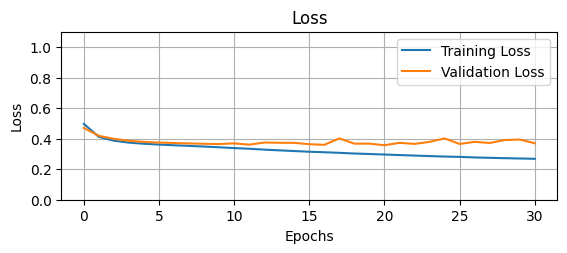

In [35]:
# Cria um subplot com 2 linhas e 1 coluna e seleciona o primeiro subplot
plt.subplot(2, 1, 1)

# Plota os valores de perda de treinamento e validação ao longo das épocas
plt.plot(history_dict_augmentation['loss'], label='Training Loss')
plt.plot(history_dict_augmentation['val_loss'], label='Validation Loss')
# Adiciona título e rótulos dos eixos ao subplot
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Opção 2: Escala manual (descomente para usar com a faixa desejada)
plt.ylim(0.0, 1.1)  # Ajusta os valores conforme necessário para a faixa de perda desejada

# Adiciona grades ao modelo e exibe o subplot
plt.grid(True)
plt.show()

#### Comparação das métricas Recall e Specificity



### Instruções para deploy
A célula plota um gráfico comparando o recall e a specificity do modelo no conjunto de validação ao longo das épocas.

### Aspectos Relevantes:
- Visualização de Dados: O gráfico ajuda a avaliar o desempenho do modelo em termos de recall e specificity, que são métricas importantes para problemas de segmentação;
Qualidade do Código: O gráfico é bem formatado, com título, legendas e eixos rotulados.

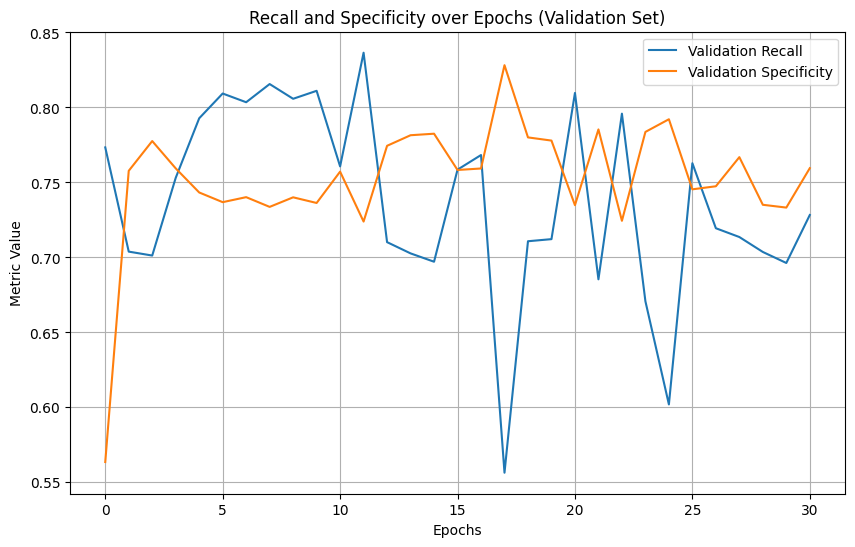

In [37]:
# Cria uma nova figura com tamanho personalizado(largura 10, altura 6)
plt.figure(figsize=(10, 6))

# Plota os valores de recall e especificidade no conjunto de validação após o treinamento com aumento de dados ao longo das épocas
plt.plot(history_dict_augmentation["val_recall"], label='Validation Recall')
plt.plot(history_dict_augmentation["val_specificity"], label='Validation Specificity')
# Adiciona título e rótulos dos eixos ao gráfico
plt.title('Recall and Specificity over Epochs (Validation Set)')
plt.xlabel('Epochs')
plt.ylabel('Metric Value')
plt.legend()

# Adiciona grades ao modelo e exibe o gráfico
plt.grid(True)
plt.show()

# Visualização de Performance

Após o treinamento, é importante saber a performance do modelo diante do sub-conjunto de dados de teste.

Então, foi feito as predições do modelo, e a partir destas, uma mostragem da visualização das imagens para comparação e também foi colocado uma mostra do gráfico de dispersão para análises diante da relação Specificity x Recall.


### Instruções para deploy
A célula realiza previsões utilizando o modelo treinado com aumento de dados no conjunto de teste (x_test_augmentation) e registra o tempo gasto para fazer as predições.

### Aspectos Relevantes:
- Avaliação do Modelo: Utiliza o método predict do modelo para obter as previsões no conjunto de teste;
- Monitoramento de Desempenho: Mede o tempo de execução das predições para análise de performance.

In [38]:
# Registra o tempo atual antes de fazer as previsões com aumento de dados
start_time_predictions_augmentation = time.time()

# Faz previsões usando o modelo treinado com aumento de dados no conjunto de teste aumentado
predictions_augmentation = model_with_augmentation.predict(x_test_augmentation)

# Calcula o tempo decorrido para fazer as previsões com aumento de dados
elapsed_time_predictions_augmentation = time.time() - start_time_predictions_augmentation

17/17 [==============================] - 3s 180ms/step


### Instruções para deploy
A célula armazena os valores reais (ground truth) das máscaras de segmentação do conjunto de teste em uma variável (expected_values_augmentation).

### Aspectos Relevantes:
- Avaliação do Modelo: Os valores esperados serão utilizados para comparar com as previsões e calcular as métricas de desempenho.

In [39]:
# Armazena os valores esperados do conjunto de teste aumentado
expected_values_augmentation = y_test_augmentation

# Converte as previsões em binárias, considerando um limite de 0.5 para definir as classes
# Valores maiores ou iguais a 200 são definidos como 255, e valores menores que 200 são definidos como 0
expected_values_augmentation[expected_values_augmentation >= 200] = 255
expected_values_augmentation[expected_values_augmentation < 200] = 0

# Normaliza os valores binários para a faixa de 0 a 1
expected_values_augmentation = expected_values_augmentation / 255.0

### Instruções para deploy
A célula converte as previsões do modelo (que estão em valores contínuos entre 0 e 1) em valores binários (0 ou 1) utilizando um limiar de 0.5. Valores acima do limiar são considerados como classe 1 (talhão) e valores abaixo como classe 0 (não talhão).

### Aspectos Relevantes:
- Pós-processamento: Transforma as previsões em um formato adequado para avaliação e comparação com as labels verdadeiras.

In [40]:
# Converte as previsões em binárias, considerando um limite de 0.5 para definir as classes
binary_predictions_augmentation = (predictions_augmentation >= 0.5).astype(int)

### Instruções para deploy
A célula calcula as métricas de acurácia, recall e precisão para avaliar o desempenho do modelo nas previsões binárias.

### Aspectos Relevantes:
- Avaliação do Modelo: As métricas fornecem informações sobre a qualidade das previsões do modelo em relação às labels verdadeiras;
- Reutilização de Código: Utiliza funções da biblioteca sklearn.metrics para calcular as métricas de forma eficiente.

In [41]:
# Calcular acurácia total
accuracy = accuracy_score(expected_values_augmentation.flatten(), binary_predictions_augmentation.flatten())

# Calcular recall total
recall = recall_score(expected_values_augmentation.flatten(), binary_predictions_augmentation.flatten())

# Calcular precisão total
precision = precision_score(expected_values_augmentation.flatten(), binary_predictions_augmentation.flatten())

print("Acurácia total:", accuracy)
print("Recall total:", recall)
print("Precisão total:", precision)

Acurácia total: 0.6718276286811986
Recall total: 0.5513930305214313
Precisão total: 0.7211277022243711


### Visualização de Imagens para Comparação

### Instruções para deploy
A célula plota 5 imagens do conjunto de teste, mostrando a previsão do modelo (máscara de segmentação binária) e a máscara real (ground truth) lado a lado.

### Aspectos Relevantes:
- Visualização de Dados: Permite visualizar as previsões do modelo e compará-las com as labels verdadeiras, ajudando a entender o desempenho do modelo e identificar possíveis erros;
- Qualidade do Código: O código é bem estruturado, utilizando um loop para plotar as imagens e ajustando o layout para evitar sobreposição.

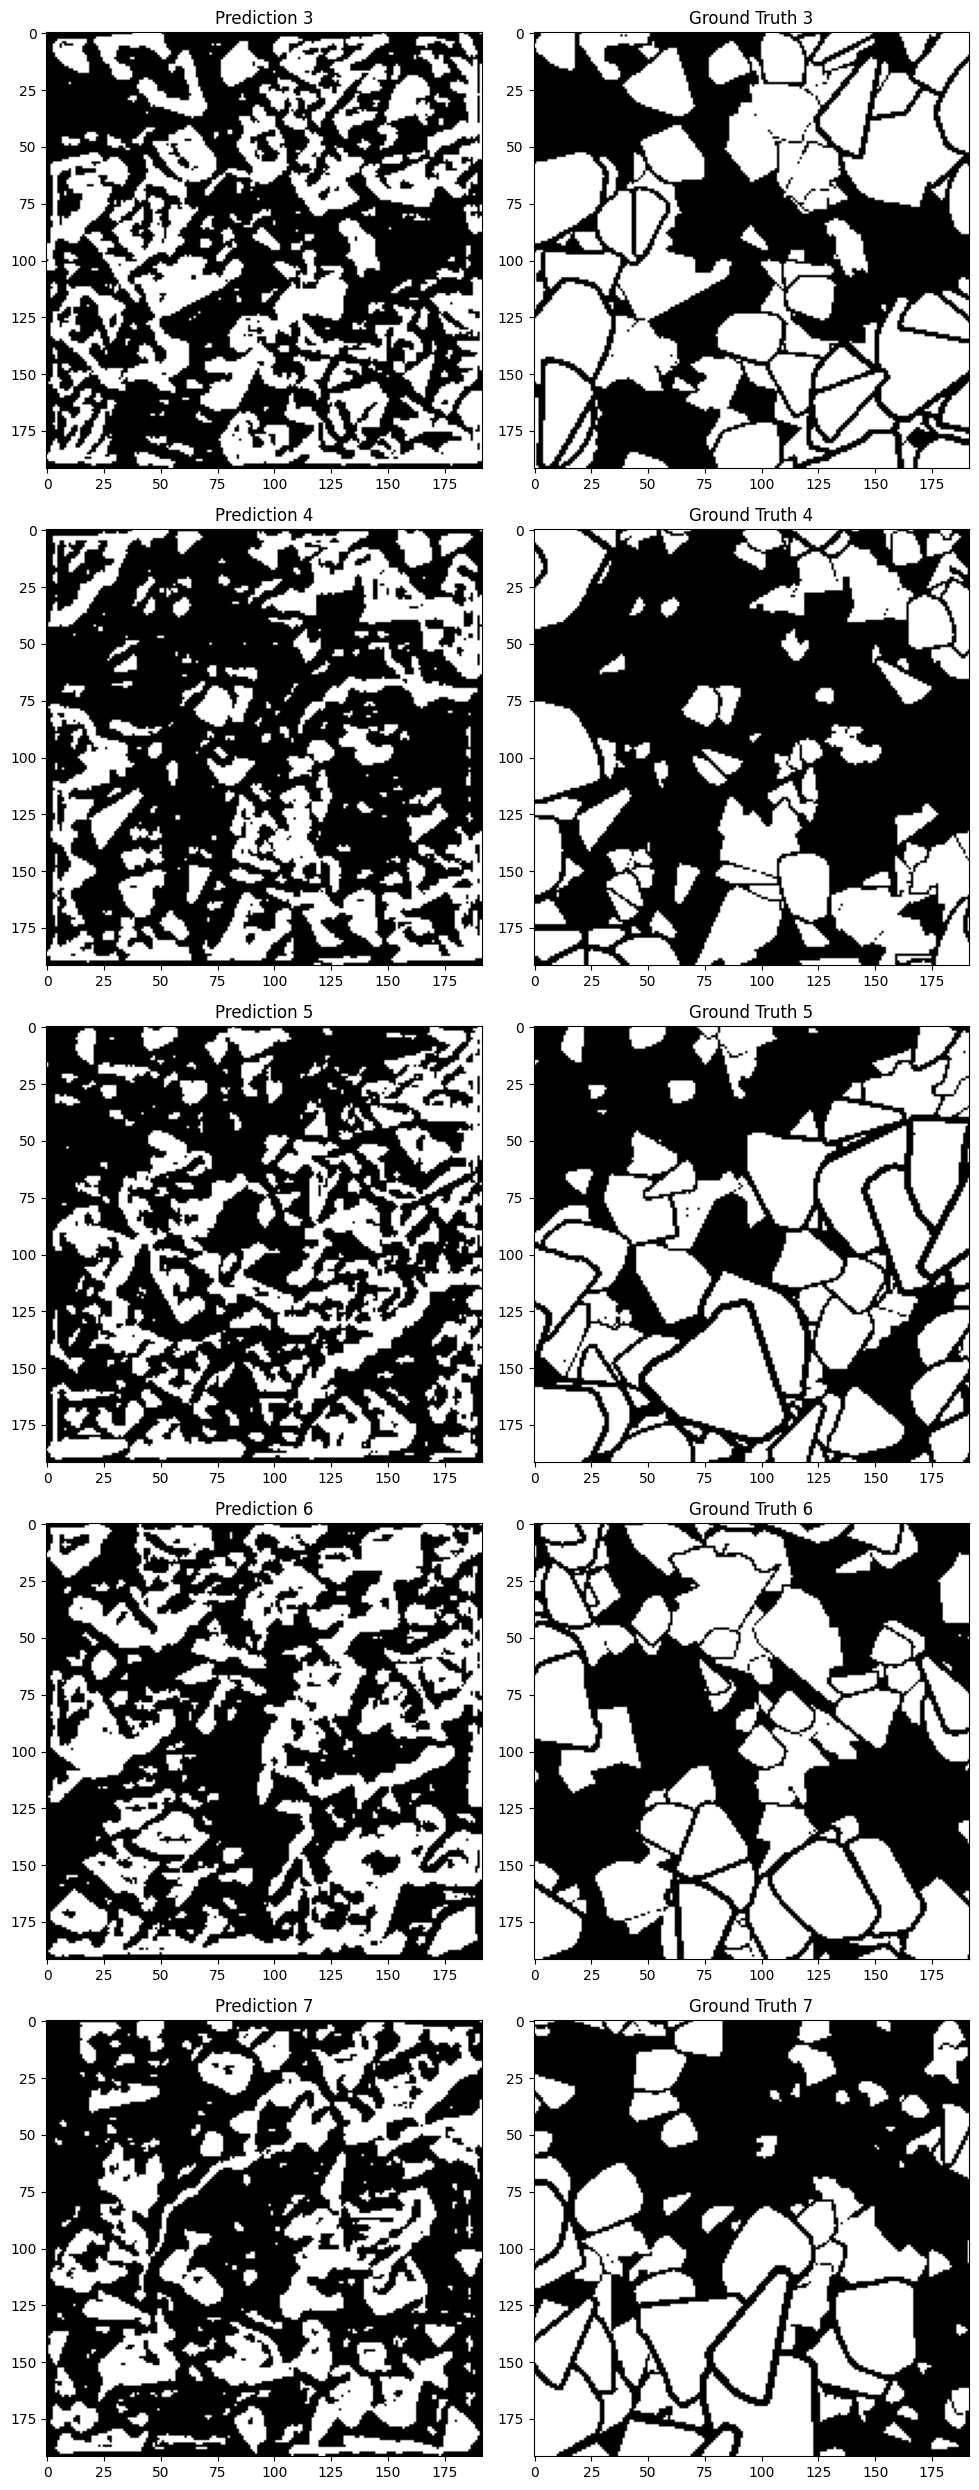

In [42]:
# Cria uma figura com uma matriz de subplots de 5 linhas e 2 colunas, com tamanho personalizado(largura 10, altura 5*5)
fig, axs = plt.subplots(5, 2, figsize=(10, 5 * 5))


for i in range(5):
    # Mostra a imagem da previsão na coluna 0 e linha i, usando a escala de cinza
    axs[i, 0].imshow(binary_predictions_augmentation[i], cmap='gray')
    # Define o título do subplot com o número da previsão
    axs[i, 0].set_title(f"Prediction {i+3}")
    # Mostra a imagem do valor esperado na coluna 1 e linha i, usando a escala de cinza
    axs[i, 1].imshow(expected_values_augmentation[i], cmap='gray')
    # Define o título do subplot com o número do valor esperado
    axs[i, 1].set_title(f"Ground Truth {i+3}")

# Ajusta automaticamente o layout dos subplots para evitar sobreposição
plt.tight_layout()

# Plota a figura com os subplots
plt.show()


### Gráfico de Dispersão Comparando o Recall x Specificity

### Instruções para deploy
A célula alcula e plota um gráfico de dispersão comparando o recall e a specificity para cada previsão do modelo no conjunto de teste.
### Aspectos Relevantes:
- Avaliação do Modelo: A célula calcula o recall e a specificity individualmente para cada previsão, fornecendo uma visão mais granular do desempenho do modelo em diferentes amostras;
- Visualização de Dados: O gráfico de dispersão permite visualizar a relação entre recall e specificity, mostrando como essas métricas variam entre as diferentes previsões;
- Qualidade do Código: O código utiliza um loop for para iterar sobre as previsões e calcular as métricas, e a biblioteca matplotlib para criar o gráfico de dispersão.

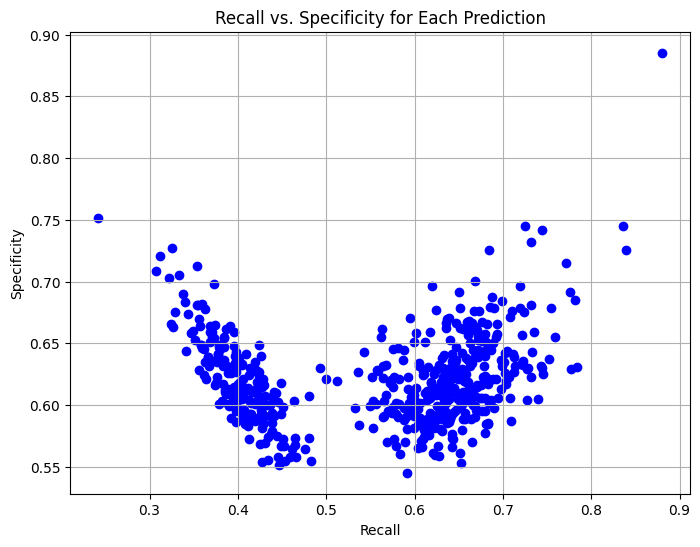

In [43]:
# Inicializa listas vazias para receber os valores de recall e specificity
recall_scores_augmentation = []
specificity_scores_augmentation = []

# Itera sobre os pares de valores esperados e valores previstos
for y_true, y_pred in zip(expected_values_augmentation, binary_predictions_augmentation):
    # Calcula o recall para cada par de valores e adiciona à lista recall_scores_augmentation
    recall_scores_augmentation.append(recall_score(y_true.flatten(), y_pred.flatten()))
    # Calcula a especificidade para cada par de valores e adiciona à lista specificity_scores_augmentation
    specificity_scores_augmentation.append(specificity(y_true, y_pred))

# Plotar os resultados
plt.figure(figsize=(8, 6))
plt.scatter(recall_scores_augmentation, specificity_scores_augmentation, color='blue')
plt.xlabel('Recall') # Define o rótulo do eixo x como "Recall"
plt.ylabel('Specificity') # Define o rótulo do eixo y como "Specificity"
plt.title('Recall vs. Specificity for Each Prediction')
plt.grid(True) # Adiciona grades ao gráfico

# Plotagem do gráfico de dispersão
plt.show()

### Pós-Processamento

Nesta sub-seção, é aplicado operações morfológicas de erosão e dilatação em uma máscara binária obtida das predições da rede, usando especificamente o "binary_prediction_augmentation" para efetuar tais aplicações. Este processo é implementado a fim de contribuir para melhorar a qualidade da segmentação levando em consideração os seguintes pontos:

- Remoção de Ruído;
- Identifique buracos/falhas na imagem;
- Isolar de elementos individuais ou unir elementos na imagem.

Aqui a erosão é útil para remover pequenas imperfeições ou para desconectar os objetos que estão ligados, encolhendo ou afinando os objetos. A erosão funciona ao aplicar um elemento estrutural a imagem, que é uma matriz pequena, para decidir se o pixel no centro do elemento deve ser considerado parte do objeto ou não. Se todos os pixels sob o elemento são parte do objeto, o pixel central é mantido, senão, é removido.

Já a dilatação é utilizada para aumentar as regiões dos objetos de uma imagem, é útil para fechar pequenos buracos dentro dos objetos ou para conectar objetos próximos, adicionando número de pixels aos limites dos objetos.
Ou seja, o pixel central é considerado parte do objeto se pelo menos um dos pixels sob o elemento estrutural for parte do objeto.

A implementação foi baseada na documentação da biblioteca OpenCV e outras fontes disponíveis a seguir:

1. OpenCV documentação: https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html
2. Exemplo real: https://medium.com/@sasasulakshi/opencv-morphological-dilation-and-erosion-fab65c29efb3
3. Detalhamento: https://www.javatpoint.com/opencv-erosion-and-dilation


#### Instruções de uso

  Representação da máscara binária utilizada:

### Instruções para deploy
A célula exibe a representação da máscara binária (binary_predictions_augmentation) que contém as previsões do modelo para o conjunto de teste. Cada elemento da matriz representa um pixel da imagem, com valor 1 para talhão e 0 para não talhão.

### Aspectos Relevantes:
- Visualização de Dados: Permite inspecionar visualmente a estrutura da matriz de previsões;
- Depuração: Útil para verificar se as previsões estão no formato esperado e se há algum problema com os valores.

In [44]:
binary_predictions_augmentation

array([[[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [1]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [1],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]]],


       [[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [1]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],
         [0],
         [1],
         ...,
         [0],


Atribuindo o "binary_mask", guardamos o array "binary_predictions_augmentation" para carregamento que contém a máscara binária predita. Fazendo esta aplicação, é possível prosseguir para a aplicação das funções de erosão e dilatação, mas antes disso é necessário converter a máscara para um tipo de dado adequado para operações morfológicas usando OpenCV.

### Instruções para deploy
A célula carrega uma máscara binária específica do array binary_predictions_augmentation (neste caso, a máscara de índice 1) e converte seu tipo de dados para *np.uint8*, que é o formato adequado para operações de processamento de imagem com a biblioteca OpenCV.

### Aspectos Relevantes:
- Pós-processamento: Prepara a máscara binária para as operações de erosão e dilatação;
- Qualidade do Código: O índice da máscara a ser carregada pode ser facilmente ajustado conforme necessário.

In [45]:
binary_mask = binary_predictions_augmentation[1]  # Ajuste o índice conforme necessário

# Ajuste do tamanho do kernel e das iterações
binary_mask = binary_mask.astype(np.uint8)

Desse modo, define-se duas funções, uma para cada processo e ambos recebem a máscara binária, o tamanho do kernel e o número de iterações como parâmetros. O kernel padrão é (2, 2) para ambas as funções, mas pode ser ajustado conforme necessário assim como o número de iterações que garante a intensidade das transformações.

### Instruções para deploy
A célula define funções para aplicar erosão e dilatação na máscara binária, além de aplicar essas operações na máscara carregada anteriormente (binary_mask).

### Aspectos Relevantes:
- Pós-processamento: A erosão e a dilatação são técnicas de morfologia matemática utilizadas para refinar a máscara de segmentação, removendo ruídos e preenchendo pequenos buracos;
- Reutilização de Código: As funções *apply_erosion* e *apply_dilation* podem ser reutilizadas em outros projetos de processamento de imagem;
- Qualidade do Código: As funções são bem documentadas com comentários explicando os parâmetros e as operações realizadas;
- Modularidade: As funções encapsulam a lógica de erosão e dilatação, tornando o código mais organizado e fácil de manter.

In [46]:
# função de aplicação da erosão
def apply_erosion(image, kernel_size=(2, 2), iterations=3):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size) # Cria um elemento estrutural(kernel) retangular com o tamanho do 'kernel_size'
    return cv2.erode(image, kernel, iterations=iterations)  # Aplica a erosão na imagem usando o kernel, repetindo a operação

# função de aplicação da dilatação
def apply_dilation(image, kernel_size=(2, 2), iterations=2):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size) # Cria um elemento estrutural(kernel) retangular com o tamanho do 'kernel_size'
    return cv2.dilate(image, kernel, iterations=iterations) # Aplica a dilatação na imagem usando o kernel, repetindo a operação


# Aplicação das modificações de erosão e dilatação
eroded_mask = apply_erosion(binary_mask) #aplica a erosão na máscara
dilated_mask = apply_dilation(eroded_mask) # aplica a dilatção na máscara

Nessa etapa é importante se atentar ao padrão do OpenCV levando em consideração a documentação mencionada anteriormente, como também ter noção que as operações morfológicas podem influenciar na métrica de recall, onde partes significativas dos objetos são perdidos, principalmente os mais pequenos e finos como linhas presentes na imagem.

#### Plotagem dos Resultados

### Instruções para deploy
A célula define funções para aplicar erosão e dilatação na máscara binária, além de aplicar essas operações na máscara carregada anteriormente (binary_mask).

### Aspectos Relevantes:
- Pós-processamento: A erosão e a dilatação são técnicas de morfologia matemática utilizadas para refinar a máscara de segmentação, removendo ruídos e preenchendo pequenos buracos;
- Reutilização de Código: As funções *apply_erosion* e *apply_dilation* podem ser reutilizadas em outros projetos de processamento de imagem;
- Qualidade do Código: As funções são bem documentadas com comentários explicando os parâmetros e as operações realizadas;
- Modularidade: As funções encapsulam a lógica de erosão e dilatação, tornando o código mais organizado e fácil de manter.

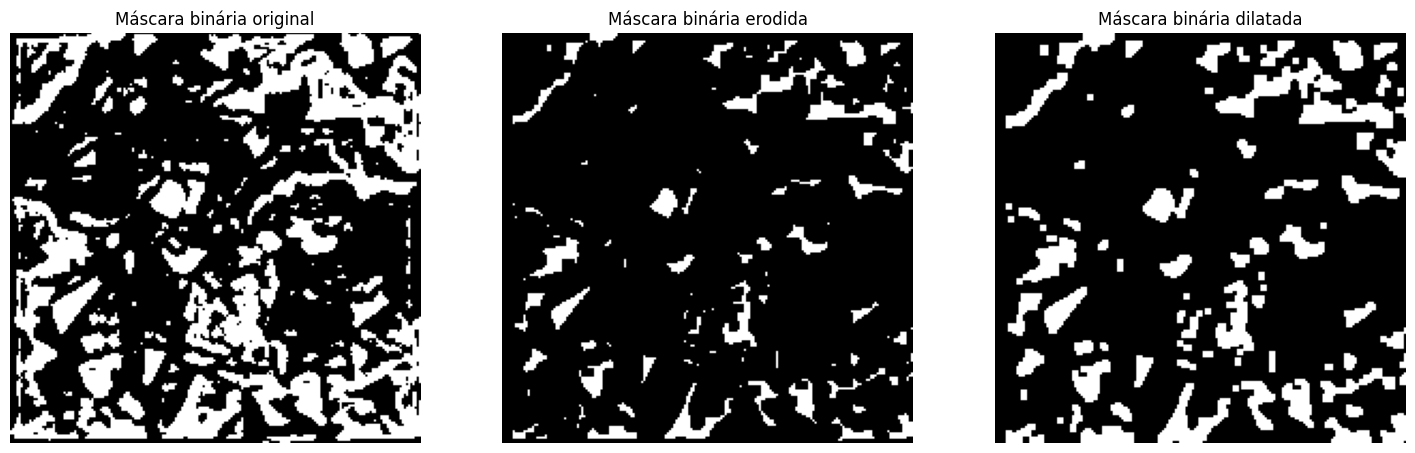

In [47]:
# Visualizando as máscaras
plt.figure(figsize=(18, 6)) # tamanho da figura
plt.subplot(1, 3, 1) # ordem das imagens
plt.imshow(binary_mask, cmap='gray') # Mostra a máscara binária original na primeira posição com escala cinza

plt.title('Máscara binária original')
plt.axis('off') # remove os eixos

plt.subplot(1, 3, 2) # ordem das imagens
plt.imshow(eroded_mask, cmap='gray') # Mostra a máscara após a aplicação da erosão
plt.title('Máscara binária erodida')
plt.axis('off') # remove os eixos

plt.subplot(1, 3, 3) # ordem das imagens
plt.imshow(dilated_mask, cmap='gray') # Mostra a máscara após a aplicação da dilatação
plt.title('Máscara binária dilatada')
plt.axis('off') # remove os eixos

plt.show() # plotagem

Por último, também é possível fazer a combinação das operações como é mostrado abaixo. A combinação é realizada aplicando erosão para remover ruídos ou objetos menores e, em seguida, dilatação para restaurar a forma do objeto principal.

### Instruções para deploy
A célula aplica a combinação de erosão e dilatação (abertura morfológica) na máscara binária e plota um gráfico comparando a máscara original com a máscara modificada.

### Aspectos Relevantes:
- Pós-processamento: A abertura morfológica é uma operação que remove pequenos objetos e suaviza os contornos da máscara, o que pode melhorar a qualidade da segmentação;
- Visualização de Dados: O gráfico permite visualizar o efeito da abertura morfológica na máscara, facilitando a avaliação da sua efetividade;
- Qualidade do Código: O código é conciso e utiliza a função *apply_dilation* definida anteriormente para aplicar a dilatação.

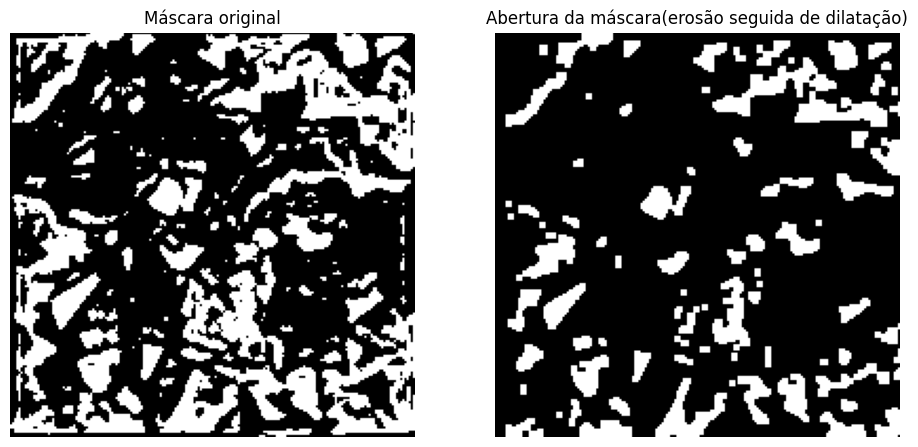

In [48]:
# Combinação das operações de erosão e dilatação
combinate_mask = apply_dilation(eroded_mask)

# Visualizando os resultados
plt.figure(figsize=(24, 6))
plt.subplot(1, 4, 1)
plt.imshow(binary_mask, cmap='gray')
plt.title('Máscara original')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(combinate_mask, cmap='gray')
plt.title('Abertura da máscara(erosão seguida de dilatação)')
plt.axis('off')

plt.show()

# Uso da GPU e CPU


### Instruções

Instruções de uso de GPU e CPU em passos:

**1º passo:** Clicar no ícone de RAM no canto superior direito;

**2º passo:** Logo após o clique, abrirá um popup;

**3º passo:** Clique no texto "Alterar o tipo de ambiente de execução";

**4º passo:** Por padrão, a opção "CPU" estará selecionada. Para alternar para "GPU", clique em "T4 GPU";

**5º passo:** O ambiente será reiniciado com o novo hardware, ou seja, o hardware selecionado no passo 4;

**6º passo:** Execute todas as células relevantes;

**7º passo:** Ao executar o código nesta seção, os dados de desempenho serão mostrados de forma representativa em uma tabela.


### Análises da CPU e GPU

Baseadas em 3 princípios:

- Tempo de Treinamento;
- Tempo de Inferência;
- Uso de Memória;


#### Análise
**Testes com CPU:**

- Tempo de Treinamento: 27 minutos;
- Tempo de Inferência: 21 segundos;
- Uso de Memória: 190 megabytes;

**Testes com T4 GPU:**

- Tempo de Treinamento: 17 minutos;
- Tempo de Inferência: 23 segundos;
- Uso de Memória: 2737 megabytes;


### Instruções para deploy
A célula apresenta uma tabela comparativa do desempenho do modelo (tempo de treinamento, tempo de inferência e uso de memória) em CPU e GPU (T4) com a utilização de data augmentation.

### Aspectos Relevantes:
- Visualização de Dados: A tabela permite comparar facilmente o desempenho entre CPU e GPU com e sem data augmentation;
- Análise de Desempenho: Os dados da tabela podem ser utilizados para avaliar o impacto da data augmentation no desempenho do modelo e no consumo de recursos;
- Qualidade do Código: O código é similar à célula anterior, facilitando a comparação dos resultados.

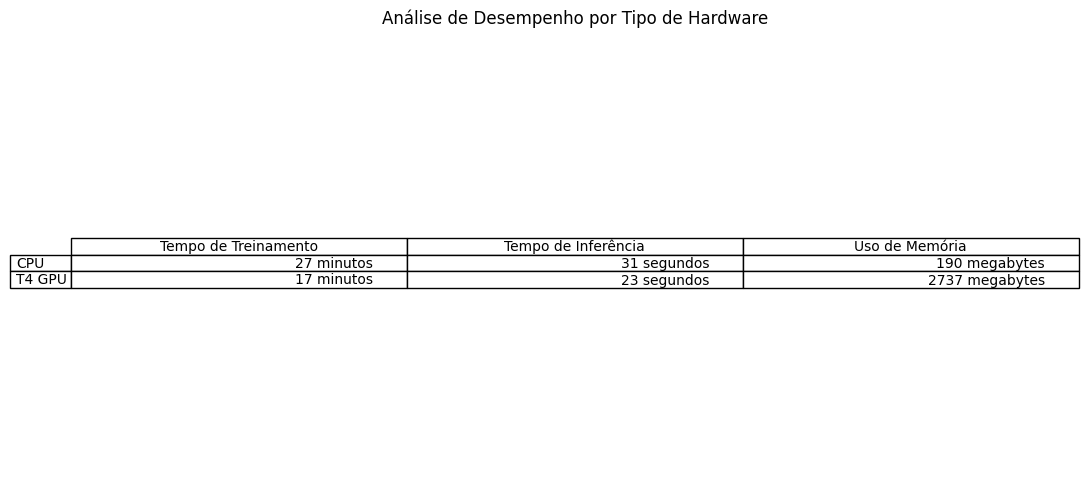

In [50]:
# Cria uma figura e um eixo usando o matplotlib com tamanho personalizado(largura 13, altura 6)
fig, ax = plt.subplots(figsize=(13, 6))


cpu_minutes_train = "{:} minutos".format(round(1640.9071357250214/60)) # Tempo de treinamento da CPU
cpu_seconds_inference = "{:} segundos".format(round(30.64234948158264)) # Tempo de inferência da CPU
cpu_memory = "{:} megabytes".format(round(198856704 / (1024 * 1024))) # Uso de memória da CPU

gpu_minutes_train = "{:} minutos".format(round(1035/60)) # Tempo de treinamento da GPU
gpu_minutos_inference = "{:} segundos".format(round(23)) # Tempo de inferência da GPU
gpu_memory = "{:} megabytes".format(round(2869882880 / (1024 * 1024))) # Uso de memória da GPU

# Cria uma lista de listas com os dados de desempenho da CPU e GPU
data = [[cpu_minutes_train, cpu_seconds_inference, cpu_memory], [gpu_minutes_train, gpu_minutos_inference, gpu_memory]]

# Define os rótulos das colunas da tabela
column_labels = ["Tempo de Treinamento", "Tempo de Inferência", "Uso de Memória"]

# Cria um dataframe
df = pd.DataFrame(data, columns=column_labels)

# Define o eixo para ajustar automaticamente e não ser visível
ax.axis("tight")
ax.axis("off")

# Cria uma tabela no eixo com os dados do DataFrame, usando os rótulos das colunas e rótulos de linha
table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=["CPU", "T4 GPU"], loc="center")

plt.title("Análise de Desempenho por Tipo de Hardware")

# Plotagem
plt.show()